### Stock Market Data Scraping in Python

In [31]:
# Import Libraries
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf, datetime as dt
import plotly.graph_objects as go, plotly.express as px
from datetime import datetime, timedelta,date
import warnings
warnings.filterwarnings("ignore")

In [32]:
# define dates to fetch data
d1=date.today().strftime('%Y-%m-%d') # End Date
d2=(date.today()-timedelta(765)).strftime('%Y-%m-%d') # Start Date

In [63]:
# load dtaset of 'GOOGL'
df=yf.download('GOOGL',start=d2, end=d1,progress=False)
df.reset_index(inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-04-13,128.000000,130.334000,127.740997,129.893997,129.893997,27928000
1,2022-04-14,130.479507,130.479507,126.600998,126.730003,126.730003,31598000
2,2022-04-18,127.000000,128.212494,126.181999,127.676498,127.676498,20808000
3,2022-04-19,127.691498,130.332993,126.999496,130.009003,130.009003,26490000
4,2022-04-20,130.891998,131.399002,127.500000,128.039993,128.039993,31696000


In [58]:
# Plot the data
dfb=df.drop(columns=['Adj Close', 'Volume'])
fig=px.line(dfb,x='Date',y=dfb.columns)
fig.show()

### Select and Plot Data For Models and Predictions

In [60]:
dfa=df[['Date','Close']]
fig=px.line(dfa,x='Date',y='Close')
fig.update_layout(title={'text':'Google Stock Price (Closing)','x':.5})
fig.show()

#### Adfuller Test to Chech Data Stationarity

In [38]:
from statsmodels.tsa.stattools import adfuller
def st_check(df):
    result=adfuller(df)
    print('Adfuller Statistics: %.3f' % result[0])
    print('P-value: %.3f' % result[1])
    if result[1] <=0.05:
        print('Data is stationary')
    else:
        print(f'P-Value {result[1]} > 0.05 so data is not stationary')
        
st_check(dfa.Close)


Adfuller Statistics: -0.236
P-value: 0.934
P-Value 0.9340319597009357 > 0.05 so data is not stationary


#### Decompose the data for trends, seasonality and noise

In [61]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose=seasonal_decompose(dfa['Close'],model='additive',period=30)

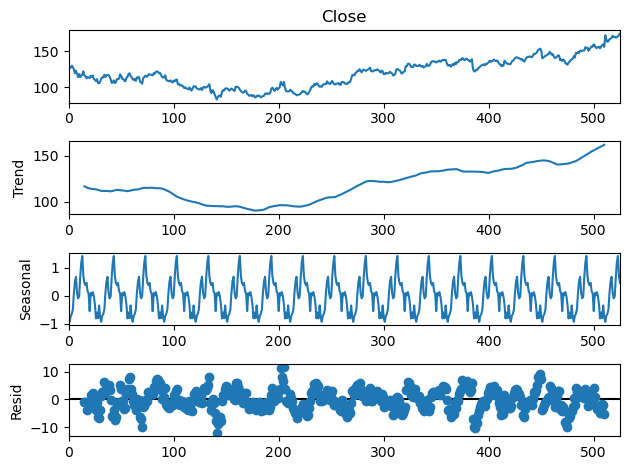

In [40]:
decompose.plot()
plt.show()

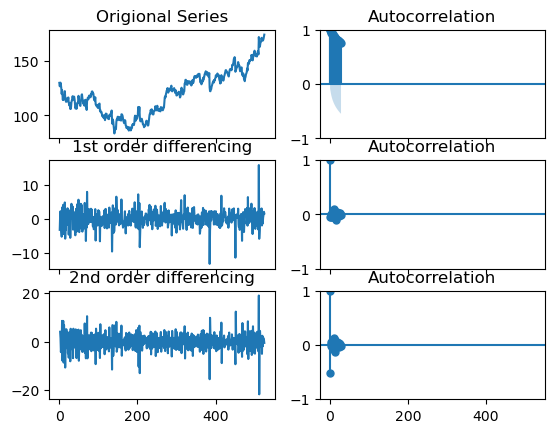

In [62]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig,ax=plt.subplots(3,2, sharex=True)
ax[0,0].plot(dfa.Close); ax[0,0].set_title('Origional Series')
plot_acf(dfa.Close,ax[0,1])
ax[1,0].plot(dfa.Close.diff()); ax[1,0].set_title('1st order differencing')
plot_acf(dfa.Close.diff().dropna(),ax[1,1])
ax[2,0].plot(dfa.Close.diff().diff()); ax[2,0].set_title('2nd order differencing')
plot_acf(dfa.Close.diff().diff().dropna(),ax[2,1])
plt.show()

#### Find Value of P

In [42]:
from statsmodels.tsa.stattools import acf,pacf
x_acf=pd.DataFrame(acf(dfa.Close),columns=['p'])
x_acf.head()

,p
0,1.000000
1,0.984936
2,0.971239
3,0.958447
4,0.946471


### Find Value of q

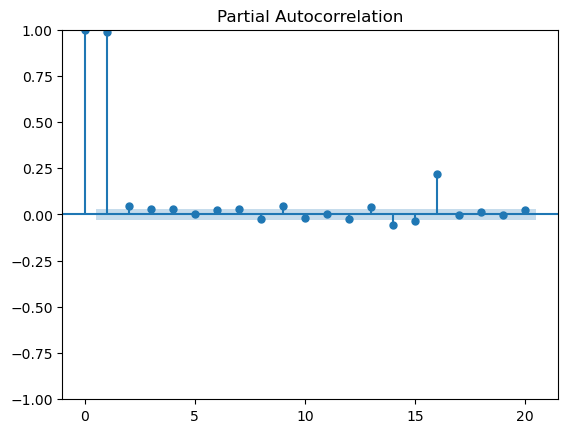

In [43]:
# Find value of q
from statsmodels.graphics.tsaplots import plot_pacf,pacf
plot_pacf(dfa.Close,alpha=.5,lags=20)
plt.show()

#### Predictions with ARIMA Model

In [44]:
# ARIMA Model With Summary
from statsmodels.tsa.arima.model import ARIMA
p,d,q=5,2,2
model=ARIMA(dfa.Close,order=(p,d,q))
model=model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  526
Model:                 ARIMA(5, 2, 2)   Log Likelihood               -1232.068
Date:                Fri, 17 May 2024   AIC                           2480.135
Time:                        12:25:16   BIC                           2514.227
Sample:                             0   HQIC                          2493.486
                                - 526                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0157      0.076    -13.312      0.000      -1.165      -0.866
ar.L2         -0.0890      0.070     -1.271      0.204      -0.226       0.048
ar.L3         -0.0793      0.070     -1.134      0.2

In [50]:
# Forecast for Next 7 days
forecast=model.predict(len(dfa.Close),len(dfa.Close)+7)
pd.DataFrame(forecast)

,predicted_mean
526,174.363519
527,174.356665
528,175.278033
529,174.688889
530,175.221881
531,176.326952
532,177.244355
533,178.319226


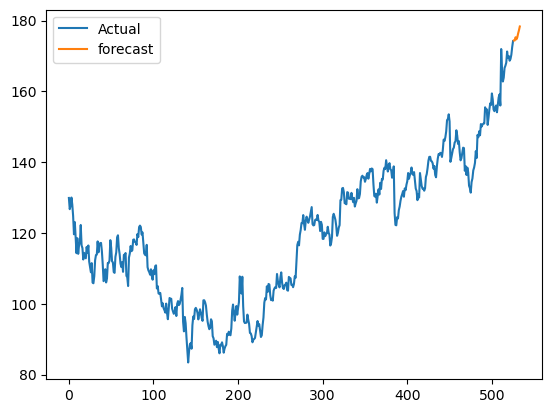

In [51]:
# Plot the Actual data and predictions
plt.plot(dfa.Close, label='Actual')
plt.plot(forecast, label='forecast')
plt.legend()
plt.show()

#### Prediction with SARAMA Model

In [46]:
# SARIMA Model With Summary
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(dfa.Close,order=(p,d,q),seasonal_order=(p,d,q,12))
model=model.fit()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  526
Model:             SARIMAX(5, 2, 2)x(5, 2, 2, 12)   Log Likelihood               -1252.610
Date:                            Fri, 17 May 2024   AIC                           2535.219
Time:                                    12:27:28   BIC                           2598.439
Sample:                                         0   HQIC                          2560.027
                                            - 526                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0354      0.050    -20.900      0.000      -1.133      -0.938
ar.L2         -0.0928      0.071   

In [53]:
# Predictions for Next 7 days
predictions=model.predict(len(dfa.Close),len(dfa.Close)+7)
pd.DataFrame(predictions)

,predicted_mean
526,174.363519
527,174.356665
528,175.278033
529,174.688889
530,175.221881
531,176.326952
532,177.244355
533,178.319226


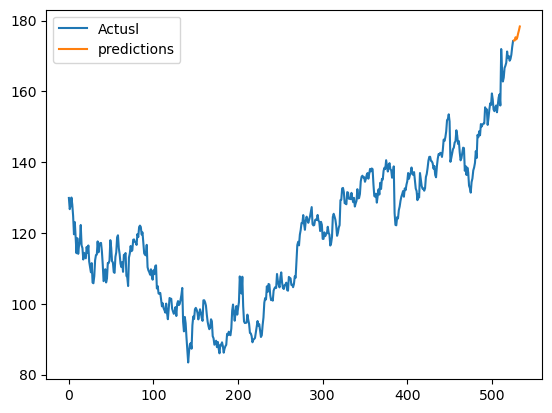

In [54]:
# Plot Actual Data and predictions
plt.plot(dfa.Close, label='Actusl')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()